In [1]:
import os
#import emcee
import rebound
import numpy as np
import pandas as pd
from numba.typed import List
from numba import jit, types
import astropy.constants as ast
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Getting the current working directory and the path to the data.
currDir = os.getcwd()

In [2]:
# Useful Constants
const ={
    'G' :  6.67430e-11, #SI
    'R_b' : 0.0677, #AU
    'R_c' : 0.1189 , #AU
    'R_d' : 0.1662, #AU
    'R_e' : 0.2138, #AU
    'R_f' : 0.2535, #AU
    'P_b' : 5.7, # days
    'P_c' : 13.2, # days
    'P_d' : 21.8, # days
    'P_e' : 31.8, # days
    'P_f' : 41,# days
    'M_b' : 3.68, #Earth
    'M_c' : 0.39, #Earth
    'M_d': 3.91, #Earth
    'M_e' : 5.57, #Earth
    'M_f': 9.6, #Earth
    'AU' : 1.496e11, #m
    'M_star' : 1.29, # solar mass
    'M_sun' : 1.988e30, # kg
    'day_to_sec' : 86400,
    'M_earth' : 5972e24, #kg
    'M_earth_sun' : 3e-6 # solar masses
}

We are modelling the system of Kepler 33, which has five planets, sublabelled 'b', 'c', 'd', 'e', 'f'.

# Handling and Formatting the Transit Timings from Kepler 33

### 1. Getting the needed data for TTVs - Setting inital parameters

In [3]:
conNum = lambda arr, idx: np.array(arr, dtype=object)[idx]

def get_transitTimingData(path):
    '''
    Extracting the timing data. One column gives the predicted transits and the other gives
    the predicted minus the observed, and the last one gives the errors in timings. The data
    file is organized as follows:
    Column 1: Period - considered to be constant (P)
    Column 2: Extra time in Period that is not expected due to TTV (pred)
    Column 3: Error in data
    '''
    # Period prediction, Period values with TTVs, Errors
    predArr, t0Arr, errArr = [], [], []
    
    # Load in the data - These are taken from Prof Rowe notes
    for file in os.listdir(path):
        d = np.loadtxt(path+'/'+file)
        
        predArr.append(d[:, 0])
        t0Arr.append(d[:, 0] + d[:, 1]) # Adding period value + TTV values
        errArr.append(d[:, 2])
    
    # Find the period of the data to determine which data file
    # corresponds to which planet and set up our arrays in the order of b, c, d, e, f
    P = np.array([np.min(arr[1:] - arr[:-1]) for arr in predArr])
    
    # We sort by the period (ie. each period corresponds to a specific planet)
    # because the data files are not in order. 
    sIdx = np.argsort(P) # Index of the files in ascending period value
    
    P_ordered = P[sIdx] # Period in order -> b, c, d, e, f
    
    # All data arrays in the order of the planets
    predArr_ordered = conNum(predArr, sIdx)
    t0Arr_ordered = conNum(t0Arr, sIdx)
    errArr_ordered = conNum(errArr, sIdx)
    
    return P_ordered, predArr_ordered, t0Arr_ordered, errArr_ordered ### Why give back P_ordered???

In [4]:
# Getting the data - Period, Predicted Period, Period+TTV, Error 
P, pred, t0, err = get_transitTimingData(currDir + '/koi707_timing')

### 2. Setting a time zero

We want to start the data at the first recorded TTV. So, we are finding the smallest inital time value out of all the planets and taking it to by our 'time zero'. The other planets will have an offset determined by the extra time before a TTV is recorded. This initial position is described by an angular distance position called 'f'.

In [5]:
# Finding the smallest inital time value
tranTime1 = np.array([arr[0] for arr in pred])
minTran = np.min(tranTime1)

b4T0 = tranTime1-minTran # Extra time for each planet

# Orbital Elements

### 1. Setting up our initial conditions

Parameters we are using: Mass (m), Eccentricity (ecc), Period (P), True anamoly (f). The only value that is left to calculate is f. The inital condition are set up according to previously stated article.

In [6]:
def fCalc(b4T0, P, e):
    '''
    To approximate the starting positions. First, we find the mean ananomaly, taking T0 as periapsis.
    Then, we approximate the eccentric ananomaly as the mean ananomaly as e is small. We then directly
    derive our true ananomaly from our eccentric ananomaly, given as the alternate form from
    https://en.wikipedia.org/wiki/True_anomaly
    '''
    M = (P - b4T0)/P # mean ananomaly approximately eccentric ananomaly when e is small.
    # The calculation to derive the true 
    beta = e/(1+np.sqrt(1-e**2))
    temp = beta*np.sin(M)/(1-beta*np.cos(M))
    f = M + 2*np.arctan(temp)
    
    return f

In [7]:
# Eccentricity
ecc = np.array([0.2, 0.05, 0.03, 0.02, 0.02])/3

# True anamoly -> Need to find it according to 'extra time'
f = fCalc(b4T0, P, ecc) # Initial position

In [8]:
# System Parameters
# Units of the REBOUND system are Solar Masses, Rad and Days

System = {
    'Names': ['b', 'c', 'd', 'e', 'f'],
    'Mass' : np.array([3.68, 18.3, 7.5, 6.6, 8.2])*const['M_earth_sun'], # Solar masses
    'Period' : np.array([5.7, 13.2,  21.8,  31.8,  41]), # Days
    'Ecc': ecc, # No units
    'Inc': np.array([np.pi/2]*5), # Rad
    'Anom': np.array(f) # Rad
}

# Rebound

In [9]:
def solve_nBody(orbE):
    '''
    Set up our system, choosing our integrator and adding our star. Subsequently, we can populate the simulation
    with planets. We use Rebound to solve for the positions of our planets, thus solving the 5 body system. 
    '''
    # Set up the system initial positions
    kep33 = rebound.Simulation() 
    kep33.integrator = 'IAS15'
    
    # Our star is at the centre of the system with no velocity etc, so no orbital elements for it except mass.
    kep33.add(m=1.26) # The units are in solar masses.
    
    # Populating the simulation with our planets. 
    for i in range(len(orbE["Names"])):
        # Plugging in our orbital parameters.
        kep33.add(m=orbE['Mass'][i], P=orbE['Period'][i], e=orbE['Ecc'][i], inc=orbE['Inc'][i], f=orbE['Anom'][i])
 
    # Moving our system to the centre of mass frame, which should be in the star
    kep33.move_to_com() 
    
    # The Kepler mission ran for 4 years, so we run this for around the same time.
    
    # the adaptive integrator requires a maximum step size, rule of thumb we ensure 20 points in our smallest period
    kep33.dt = np.min(orbE['Period'])/20 #maximum step size in our integrator
    
    
    # Information 
    times = []
    exoPos = {
        'star': [],
        'b': [],
        'c': [],
        'd': [],
        'e': [],
        'f': []
    } 
    
    # Set the time frame for the integration
    length_integration = 4 # years
    
    # intial time of the simulation
    initial_time = kep33.t
    
    while kep33.t - initial_time < 365*length_integration:
        # append the times 
        times.append(kep33.t)
        
        # append star position to ensure it is not moving
        exoPos['star'].append([kep33.particles[0].x,kep33.particles[0].y,kep33.particles[0].z])
        
        # append x,y,z position for each planet
        for i in range(len(exoPos)-1):
            planet = kep33.particles[i+1] # add 1 to skip the star
            exoPos[orbE['Names'][i]].append([planet.x, planet.y, planet.z])

        # Integrate forward by one step, the step size is adapted by the integrator
        kep33.integrate(kep33.t + 1)   ############################################################################# 0.1?? good or bad???
        # to get multiple positions we integrate over 0.1 day but 
        # the integrator chooses an adaptive step size

    return exoPos, times


In [10]:
class Orbit:
    def __init__(self, planet_path):
        self.x = planet_path[:, 0]
        self.y = planet_path[:, 1]
        self.z = planet_path[:, 2]

In [11]:
def get_orbits(planet_positions):
    '''
    Converts values from nbody solver to orbit objects
    '''
    
    orbits = []
    
    planet_positions['star'] = np.array(planet_positions['star'])
    star_orbit = Orbit(planet_positions['star'])

    for i in range(len(planet_positions)-1):
        planet_positions[System['Names'][i]] = np.array(planet_positions[System['Names'][i]])
        orbits.append(Orbit(planet_positions[System['Names'][i]]))
        
    return star_orbit, orbits


def get_model(planets, adjusted_pars, properties):
    """
    Input: the names of the planets, the parameters that have been adjusted and which parameter has been adjusted
    
    Output: An array of the star position, array of orbits of each planet, times array
    
    Example usage:
    function(['a','b'], [[2,6],[3,4]], ['Mass','Period'])
    """
    for p, planet in enumerate(planets):
        index = System['Names'].index(planet)
        for i,prop in enumerate(properties):
            (System[prop])[index] = adjusted_pars[p][i]                
    
    planet_positions, times = solve_nBody(System)
    
    star_orbit, orbits = get_orbits(planet_positions)
    return star_orbit, orbits, times

# MCMC

### 1. Getting Transit Times from the N-Body simulation

This is the data that will be used to compare in our MCMC code to determine if the parameters are a good fit.

In [12]:
# Using jit to optimise our for loop!
# @jit(nopython=True)
def getTransits(x, y, time):
    '''
    With our (x,y) position from the data, we want to be able to find where the transits are. This allows us
    to compare our findings to the data. Define the transit to be at y=0 in the axis on the right (x positive)
    '''
    # The y values are actually z values when running the n body since we use a pi/2 inclination
    # simulation according to our inclination value
    
#     # For the values to be compatible with numba
#     x = x.astype(np.float64)
#     y = y.astype(np.float64)
#     time = time.astype(np.float64)
#     t_transit = List.empty_list(types.float64)
    t_transit = []
    
    # First, we check if we have a y=0 solution at a positive x value 
    # If that is the case, the planet is at the right position for it to be a TTV
    if len(np.where(y == 0)[0]) != 0:
        zeroMask = np.logical_and(x>=0, y==0)
        indices = np.arange(len(y))[zeroMask]
        for idx in indices:
            # Adding time according to index
            t_transit.append(float(time[idx])) #### TO CHECK
        
    else:
        # Getting array where y value changes sign
        index = np.where(np.diff(np.sign(y)))[0] 

        for i in index:

            if np.abs(x[i]) == x[i]: # Verifying if x is positive
                
                if i == len(index):
                     t_transit.append(time[i])
                else:
                    # Taking proportion to interpolate time value at y=0
                    diff = np.abs(y[i]-y[i+1])
                    prop = np.abs(y[i])/diff
                    new_dt = prop*(time[i]-time[i+1])
                    t = time[i]+new_dt #Time at index and additional time
                    t_transit.append(float(t))  
    
    return np.sort(t_transit) # Making sure the time is in ascending order

def systemTransits(orbPars):
    '''
    Input: Orbital parameters to be changed by MCMC (array of arrays) 
    Output: Array of arrays of transit times
    
    We compute the simulation and get our transit times from this
    '''
    # What we identify in here is what will change in the function - NEED TO MODIFY ACCORDING TO WHAT CHANGES
    # orbPars = [[],[],[]] -> [b, c, d]
    star_orbit, p_orbit, times = get_model(['b', 'c', 'd', 'e', 'f'], orbPars, ['Mass', 'Ecc', 'Inc'])
    transits = []
    times = np.array(times)
    
    # Loop through each simulated orbit, so we compute the transits for each of the planets. 
    for orbit in p_orbit:
        tPlanet = getTransits(orbit.x, orbit.y, times)
        transits.append(np.array(tPlanet))
        
#     for j in range(exoPos.shape[1]):    
#         tPlanet = getTransits(, , times[j]) # x, y, time
#         transits.append(np.array(tPlanet))
        
    return np.array(transits, dtype=object)

### 2. Correction to data before running the MCMC

In [13]:
def padObs(t0, pred, err, period):
    '''
    Where we add zero values to where the difference is not the period, which is given by our predicted array.
    '''
    pDiff = pred[1:] - pred[:-1]
    pGreater = pDiff - period >= 10**-4
    numZeros = np.array(pDiff[pGreater]//period - 1, dtype=int)
    
    insertStartIdx = np.where(pGreater)[0] + 1
    insertIdx = np.array([], dtype=int)
    
    # We need to 'pad' out the insertIdx array to reflect the number of values to insert.
    for i, numZero in enumerate(numZeros):
        insertIdx = np.append(insertIdx, np.tile(0, numZero) + insertStartIdx[i])
    
    t0Corr = np.copy(t0)
    errCorr = np.copy(err)
    errInsert = t0[insertIdx - 1] # Basically the transit value after which we insert zeros.
    
    # Insert the value at the desired positions but as the array shifts, we need to enumerate.
    for i, idx in enumerate(np.array(insertIdx, dtype=int)):
        t0Corr = np.insert(t0Corr, idx+i, 0)  # Insert 0 behind the original value
        errCorr = np.insert(errCorr, idx+i, errInsert[i])  # Insert 0 behind the original value
        
    return t0Corr, errCorr

In [14]:
# We correct our observational data in order to match it to the model values here.
t0Corr, t0ErrCorr = [], []

for i in range(len(System['Names'])):
    
    # Handling the padding situation. 
    padded, paddedErr = padObs(t0[i], pred[i], err[i], P[i])
   
    # Subtracting the initial offset that the model utilises to properly set up the system.
    padded[padded != 0] -= minTran
    t0Corr.append(padded)
    t0ErrCorr.append(paddedErr)
    
t0Corr = np.array(t0Corr, dtype=object)
t0ErrCorr = np.array(t0ErrCorr, dtype=object)

# Thus, we can define our data as:
data = (t0Corr, t0ErrCorr)

### 3. Setting Priors to limit the parameter search

This will limit the search for the good fit parameters and make sure the simulator does not input an invalid value (ex: ecc of -1)

In [15]:
# This is the upper bound for the eccentricity, so it becomes our prior.
global eccUpperPrior, eccLowerPrior # We make it a global variable because we use it later for our MCMC
eccUpperPrior = np.array([0.2, 0.05, 0.03, 0.02, 0.02])
eccLowerPrior = np.array([0, 0, 0, 0, 0])

# These are our upper and lower bounds for our masses, and we use them as our priors
global mLowerPrior, mUpperPrior
mLowerPrior, mUpperPrior = np.array([0.1, 0.1, 0.1, 6.6-1.0, 8.2-1.2]), np.array([20, 19, 8.2, 6.6+1.1, 8.2+1.6])

### 4. MCMC Functions

In [76]:
def chi_fun(y, planetMod, yerr):   # do not change will break everything 
    return np.sum(((y - planetMod))**2/y)
    

def like(theta, y, yerr, old_chi):
    '''
    Input:
    Output:
    We organise our parameters and then plug them into our nBody simulation to get our simulated transits.
    We have to account for a difference in length between the original data and the simulated data. 
    '''
    ## To check
    ymodel = systemTransits(theta)
    y = y[0]
    nModel = len(ymodel)
    chiSq = np.zeros((nModel,))
    
    for i in range(nModel):
        planetMod = ymodel[i]

        if len(planetMod) > len(y[i]): # To match the lengths of the model versus the observed data. 
            planetMod = planetMod[:len(y[i])]

        else: #f len(planetMod) < len(y[i]):
            # This is an unlikely case and will hopefully not happen as we hold our period constant.
            y[i] = y[i][:len(planetMod)]
            yerr[i] = yerr[i][:len(planetMod)]
                    
        # MCMC has a step to do this 
        # Will we keep this step or will we not? This is what determines this. 
        chiSq[i] = chi_fun(y[i], planetMod, yerr[i])
    
    chiSq = np.sum(chiSq)
    Like = np.exp(-0.5*(chiSq-old_chi))
    
    
    #MOVE THIS**********************************************************************************************************
    file = open('chi_param_chain.txt', 'a') # Updating txt file
    file.write(str(chiSq)+'\t'+str(theta)+'\n')
    file.close()
    
    return Like, chiSq

# Setting up boundary conditions
def prior(theta):
    '''
    Our priors decide whether or not our proposed values are valid. Our eccentricity values are less than our
    initial values, therefore, our prior must always be less than these values. 
    '''
    # Check conditions
    massCon = np.any(np.logical_and(mLowerPrior > theta[0], mUpperPrior < theta[0]))
    eccCon = np.any(np.logical_and(eccLowerPrior > theta[1], eccUpperPrior < theta[1]))
    
    # We want our true ananomaly to be between 0 and 2*pi because we want it to be within a circle. 
    fCon = np.any(np.logical_and(0 > theta[2], 2*np.pi < theta[2]))

     # Give back a big value if we get unwanted parameters, to 'cancel' out the result
    if massCon or eccCon or fCon:
        return -np.inf 
    
    return 0.0

def prob(theta, y, yerr, old_chi, nExo=5):
    '''
    This calculates the probability of whether or not we take the step. This is done in several steps.
    We unpack and reshape our parameters and then test where or not they pass the priors. If they do not,
    then, the value is automatically discarded.
    '''
    ## TO CHECK
    thetaUnpacked = np.array([np.array(theta[:,0]), np.array(theta[:,1]), np.array(theta[:,2])])
    lp = prior(thetaUnpacked) # Checking if the priors have been satisfied. 
    
    if not np.isfinite(lp):
        return -np.inf
    
    likeliness, chi = like(theta, y, yerr, old_chi)
    
    return lp + likeliness, chi

### 5. Running MCMC

In [77]:
def run_mcmc(pars, data, nsamp, dstep, err, change_dstep = False):
    
    npar = len(pars.flatten())
    model = systemTransits(pars)
    like0, chisq = like(pars, data, err, 0) # We dont actually care about the likelihood value here
    
    chain = []
    chivec = []
    count = 0
    
    while (count<1000):
        if change_dstep == True:
            for i in range(nsamp):
                pnew = pars+np.random.randn(npar)*new_dstep
                like_ratio, chi_new = prob(pars, data, err, chisq)

                if like_ratio > np.random.rand(1)[0]:
                    pars = pnew
                    chisq = chi_new

                chain.append(pars)
                chivec.append(chisq)

                change_dstep = False
        else:

            for i in range(nsamp):
                pnew = pars+np.random.randn(5,3)*dstep
                like_ratio, chi_new = prob(pars, data, err, chisq)

                if like_ratio > np.random.rand(1)[0]:
                    pars = pnew
                    chisq = chi_new

                chain.append(pars)
                chivec.append(chisq)


        # Setting a condition in case our chi square is not improving
        if len(chivec) > 501:

            if chivec[-1]-chivec[-501]<1e-4:
                new_dstep = np.array([0]) ### WHAT SHOULD WE PUT
                changed_dstep = True
                count = 0
        count+=1
    print("done")
    return chain,chivec

In [78]:
#Resetting file, so each time we write, it is better. 
reset = open("chi_param_chain.txt",'w')
reset.close()

#Adding title
file =  open('chi_param_chain.txt', 'a')
file.write('chi\tparam\n')
file.close()

# Mass, Eccentricity, Anomaly
theta = np.array([[System['Mass'][0], System['Ecc'][0], System['Inc'][0]], 
                  [System['Mass'][1], System['Ecc'][1], System['Inc'][1]],
                  [System['Mass'][2], System['Ecc'][2], System['Inc'][2]], 
                  [System['Mass'][3], System['Ecc'][3], System['Inc'][3]], 
                  [System['Mass'][4], System['Ecc'][4], System['Inc'][4]]])

dstep = 0.0001
theta = theta+0.01
nsamp = len(data)


In [79]:
chain, chivec = run_mcmc(theta, data, nsamp, dstep, err)


KeyboardInterrupt: 

### 6. Verifying Convergence

In [121]:
with open('chi_param_chain.txt','r') as file:
    lines =  file.readlines()
lines = lines[1:]
chi=[]

for i,line in enumerate(lines):
    if (i % 5) == 0:  # This will skip every 5th line (i.e., lines 5, 10, 15, etc.)
        chi.append(float(line.split('\t')[0]))

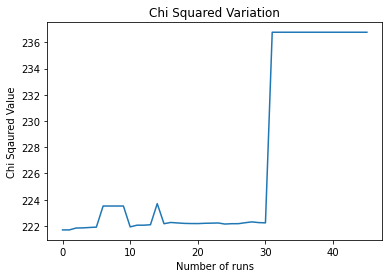

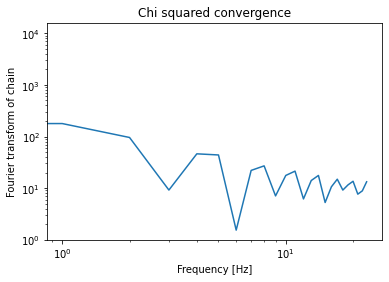

In [122]:
#chi_data = np.genfromtxt('chi_param_chain.txt', delimiter='\t', skip_header=1)
#chi = chi_data[:,0]

fft_chi = np.fft.rfft(chi)

# Plotting the actual chi sqaure values stored in txt file
plt.plot(chi)
plt.xlabel('Number of runs')
plt.ylabel('Chi Sqaured Value')
plt.title('Chi Squared Variation')
plt.show()

# Plotting the chi square value in Fourrier Space to verify convergence
plt.plot(np.abs(fft_chi))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Fourier transform of chain')
plt.title('Chi squared convergence')
plt.xscale('log')
plt.yscale('log')
plt.show()